In [24]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import sys
sys.path.append('/Users/rociokiman/Documents/Gaia-Cupid/ActivityAgeRelation/banyan_sigma')
from banyan_sigma import banyan_sigma
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
import random
%config InlineBackend.figure_format = 'retina'

In [25]:
literature_search = Table.read('Catalogs/literature_search_compatible_gaia.fits')

In [26]:
mg_ref = Table.read('Catalogs/moving_groups_ref.csv',format='csv')
source_ref_table = Table.read('Catalogs/source_ref.csv',format='csv')

In [27]:
len(literature_search)

86085

# Defining mask to clean the sample

### Distinguish accreation from chromospheric emission

In [28]:
def spt_to_g_rp(spt):
    """
    Relation from Kiman et al. 2019
    """
    return -0.0036*spt**2 + 0.11*spt + 0.89

def def_mask_acc(color,ewha):
    """
    White, R. J. & Basri, G. 
    VERY LOW MASS STARS AND BROWN DWARFS IN TAURUS-AURIGA. 
    Astrophys. J. 582, 1109–1122 (2003).
    """
    if(~np.isnan(color+ewha)):  #If any is nan I cannot make a decision if they are accreating
        if(color<spt_to_g_rp(2.7)):
            return ewha < 10
        elif(color<spt_to_g_rp(5.7)):
            return ewha < 20
        elif(color>=spt_to_g_rp(5.7)):
            return ewha < 40
        else:
            return False
    else:
        return True

In [29]:
mask_acc = []
for x,y in zip(literature_search['phot_g_mean_mag']-literature_search['phot_rp_mean_mag'],literature_search['ewha_all']):
    mask_acc.append(def_mask_acc(x,y))
mask_acc = np.array(mask_acc)

#If one of the measurements of the same star is accreating, all are. 
for i in range(1,int(max(literature_search['same_star']))+1):
    mask_same_star = literature_search['same_star'] == i
    if(any(mask_acc[mask_same_star]==False)):
        #print(mask_acc[mask_same_star])
        #print(literature_search['ewha_all'][mask_same_star])
        mask_acc[mask_same_star]=False
        
#for i in range(1,int(max(literature_search['same_star']))+1):
#    mask_same_star = literature_search['same_star'] == i
#    if(any(mask_acc[mask_same_star]==False)):
#        print(mask_acc[mask_same_star])
#        print(literature_search['ewha_all'][mask_same_star])

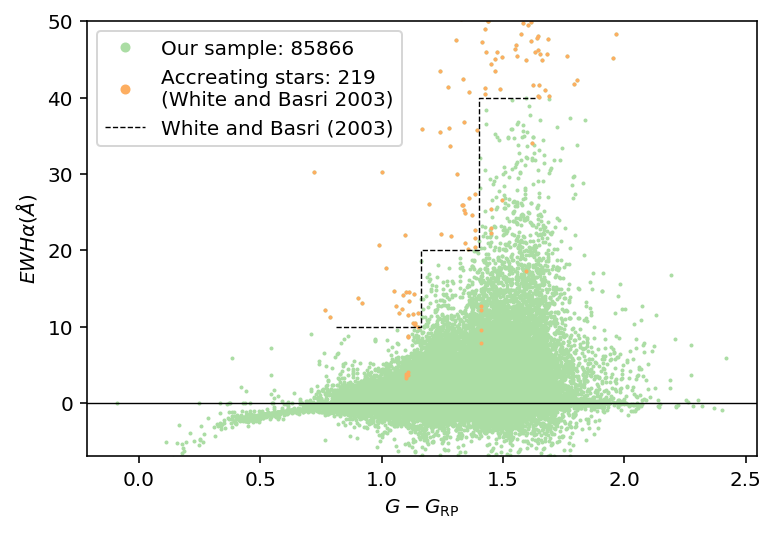

In [30]:
N = 10
linewidth = 0.7
x1 = np.linspace(spt_to_g_rp(-.7),spt_to_g_rp(2.7),N)
y1 = np.ones(N)*10
x2 = np.linspace(spt_to_g_rp(2.7),spt_to_g_rp(5.7),N)
y2 = np.ones(N)*20
x3 = np.linspace(spt_to_g_rp(5.7),spt_to_g_rp(10),N)
y3 = np.ones(N)*40
plt.plot(literature_search['phot_g_mean_mag']-literature_search['phot_rp_mean_mag'],literature_search['ewha'],
         '.',markersize=2,color='#abdda4',label='Our sample: {}'.format(len(literature_search['phot_rp_mean_mag'][mask_acc])))
plt.plot(literature_search['phot_g_mean_mag'][~mask_acc]-literature_search['phot_rp_mean_mag'][~mask_acc],literature_search['ewha'][~mask_acc],
         '.',markersize=2,label='Accreating stars: {}\n(White and Basri 2003)'.format(len(literature_search['phot_rp_mean_mag'][~mask_acc]))
         ,color='#fdae61')
#plt.plot(literature_search['phot_g_mean_mag'][~mask_abs]-literature_search['phot_rp_mean_mag'][~mask_abs],literature_search['ewha'][~mask_abs],
#         '.',markersize=2,label='Stars in absorption: {}'.format(len(literature_search['phot_g_mean_mag'][~mask_abs])),
#         color='#2b83ba')
plt.plot(np.concatenate((x1,x2,x3)),np.concatenate((y1,y2,y3)),'--k',linewidth=linewidth,
         label='White and Basri (2003)')
plt.axhline(y=0,color='k',linewidth=linewidth)
plt.ylim(-7,50)
plt.legend(markerscale=4)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$EWH\alpha (\AA)$')
plt.savefig('Figures/limits_halpha.png',dpi=300)

# Running Banyan on literature sample of stars

In [31]:
ra = np.array([float(x) for x in literature_search['ra_x']])
ra_err = np.array([float(x) for x in literature_search['ra_error']])
dec = np.array([float(x) for x in literature_search['dec_x']])
pmra = np.array([float(x) for x in literature_search['pmra']])
pmra_error = np.array([float(x) for x in literature_search['pmra_error']])
pmdec = np.array([float(x) for x in literature_search['pmdec']])
pmdec_error = np.array([float(x) for x in literature_search['pmdec_error']])
parallax = np.array([float(x) for x in literature_search['parallax']])
parallax_error = np.array([float(x) for x in literature_search['parallax_error']])
rv = np.array([float(x) for x in literature_search['radial_velocity']])
rv_error = np.array([float(x) for x in literature_search['radial_velocity_error']])

In [32]:
len(ra)

86085

In [33]:
mask_run_banyan = (~np.isnan(ra+dec+pmra+pmra_error+pmdec+pmdec_error+parallax+parallax_error)
                   * (parallax/parallax_error > 8)
                   * mask_acc)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
len(ra[mask_run_banyan])

45166

In [35]:
OUTPUT_STRUCTURE1 = banyan_sigma(ra=ra[mask_run_banyan], dec=dec[mask_run_banyan], 
                                 pmra=pmra[mask_run_banyan], pmdec=pmdec[mask_run_banyan], 
                                 epmra=pmra_error[mask_run_banyan], 
                                 epmdec=pmdec_error[mask_run_banyan],
                                 rv=rv[mask_run_banyan], erv=rv_error[mask_run_banyan], 
                                 plx=parallax[mask_run_banyan], 
                                 eplx=parallax_error[mask_run_banyan])

In [36]:
prob_ya_literature = np.array(OUTPUT_STRUCTURE1['YA_PROB']).reshape(len(OUTPUT_STRUCTURE1['YA_PROB']),)
best_ya_literature = np.array(OUTPUT_STRUCTURE1['BEST_YA']).reshape(len(OUTPUT_STRUCTURE1['BEST_YA']),)

In [37]:
highprob_literature = prob_ya_literature > 0.9


In [38]:
highprob_literature

array([ True, False, False, ..., False, False, False])

In [39]:
len(best_ya_literature[highprob_literature])

1951

### Mask banyan members

### Praesepe Members

In [40]:
source_id_praesepe = np.loadtxt('Catalogs/source_id_pra.txt') #These where previously run with banyan

In [41]:
bf_pra = np.array([True if x in source_id_praesepe else False for x in literature_search['source_id']])

In [42]:
def remove(string): 
    return string.replace(" ", "")

In [43]:
#Making sure the true members in Praesepe have the right age
for i in range(len(literature_search['group_name'])):
    if(remove(literature_search['group_name'][i])=='PRA' and bf_pra[i]):
        literature_search['group_name'][i] = 'PRA'
        literature_search['group_num'][i] = mg_ref['group_num'][mg_ref['name']=='PRA'][0]
        literature_search['age'][i] = mg_ref['age'][mg_ref['name']=='PRA'][0]
        literature_search['age_error'][i] = mg_ref['age_error'][mg_ref['name']=='PRA'][0]

### Final membership mask: Literature checked with Banyan + Praesepe

In [44]:
mask_membership = np.logical_or(highprob_literature,bf_pra[mask_run_banyan])

### New catalog with only high likelihood members

In [45]:
mg_highlike_members = literature_search[mask_run_banyan][mask_membership]
mg_highlike_members['ya_prob'] = prob_ya_literature[mask_membership]
mg_highlike_members['best_ya'] = np.array([str(x) for x in best_ya_literature[mask_membership]])

In [46]:
# Not accreating stars, good parallax and has astrometry and were confirmed as members
len(mg_highlike_members)

2009

### New catalog with non members

In [47]:
literature_search_non_members = literature_search[mask_run_banyan][~mask_membership]

In [48]:
# Not accreating stars, good parallax and has astrometry but were not confirmed as members
len(literature_search_non_members)

43157

### Correcting groups that don't agree in the high likelihood members catalog

In [ ]:
for i in range(len(mg_highlike_members)):
    if(mg_highlike_members['group_name'][i]!=mg_highlike_members['best_ya'][i]):
        if(mg_highlike_members['group_name'][i]!='PRA'):
            mask = mg_highlike_members['best_ya'][i] == mg_ref['name']
            mg_highlike_members['group_name'][i] = mg_ref['name'][mask][0]
            mg_highlike_members['group_num'][i] = mg_ref['group_num'][mask][0]
            mg_highlike_members['age'][i] = mg_ref['age'][mask][0]
            mg_highlike_members['age_error'][i] = mg_ref['age_error'][mask][0]
        elif(mg_highlike_members['group_name'][i]=='PRA'):
            mg_highlike_members['best_ya'][i] = 'PRA'
            mg_highlike_members['ya_prob'][i] = np.nan

# Save samples

## Moving groups members

Halpha column for compatible members, and another columns for all of the moving group members

In [80]:
mg_highlike_members.columns

<TableColumns names=('ra','dec','spt','ewha','ewha_error','lhalbol','lhalbol_error','age','age_error','group_num','group_name','source_num','source_ref','ewha_all','ewha_error_all','same_star','ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng','source_id','ra_x','ra_error','dec_x','dec_error','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','duplicated_source','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_bp_mean_mag','phot_rp_mean_flux','phot_rp_mean_flux_error','phot_rp_mean_mag','bp_rp','radial_velocity','radial_velocity_error','rv_nb_transits','teff_val','a_g_val','e_bp_min_rp_val','radius_val','lum_val','angDist','ya_prob','best_ya')>

In [81]:
len(mg_highlike_members)

2253

In [82]:
fullsample_mg = Table()

In [83]:
fullsample_mg['ra'] = np.array(mg_highlike_members['ra'])
fullsample_mg['dec'] = np.array(mg_highlike_members['dec'])
fullsample_mg['ra_gaia'] = np.array(mg_highlike_members['ra_x'])
fullsample_mg['dec_gaia'] = np.array(mg_highlike_members['dec_x'])
fullsample_mg['spt'] = np.array(mg_highlike_members['spt'])
fullsample_mg['source_id_gaia'] = np.array(mg_highlike_members['source_id'])
fullsample_mg['phot_g_mean_mag'] = np.array(mg_highlike_members['phot_g_mean_mag'])
fullsample_mg['phot_rp_mean_mag'] = np.array(mg_highlike_members['phot_rp_mean_mag'])
fullsample_mg['phot_bp_mean_mag'] = np.array(mg_highlike_members['phot_bp_mean_mag'])
fullsample_mg['parallax'] = np.array(mg_highlike_members['parallax'])
fullsample_mg['parallax_error'] = np.array(mg_highlike_members['parallax_error'])
fullsample_mg['ewha'] = np.array(mg_highlike_members['ewha'])
fullsample_mg['ewha_error'] = np.array(mg_highlike_members['ewha_error'])
fullsample_mg['ewha_all'] = np.array(mg_highlike_members['ewha_all'])
fullsample_mg['ewha_error_all'] = np.array(mg_highlike_members['ewha_error_all'])
fullsample_mg['lhalbol'] = np.array(mg_highlike_members['lhalbol'])
fullsample_mg['lhalbol_error'] = np.array(mg_highlike_members['lhalbol_error'])
fullsample_mg['age'] = np.array(mg_highlike_members['age'])
fullsample_mg['age_error'] = np.array(mg_highlike_members['age_error'])
fullsample_mg['group_num'] = np.array(mg_highlike_members['group_num'])
fullsample_mg['group_name'] = np.array(mg_highlike_members['group_name'])
fullsample_mg['ya_prob'] = np.array(mg_highlike_members['ya_prob'])
fullsample_mg['source_num'] = np.array(mg_highlike_members['source_num'])
fullsample_mg['source_ref'] = np.array(mg_highlike_members['source_ref'])

In [84]:
len(fullsample_mg)

2253

In [85]:
fullsample_mg.sort(['source_ref', 'ra', 'dec'])

# Save final sample

In [86]:
fullsample_mg.write('Catalogs/literature_search_mg.fits',format='fits',overwrite=True)

In [87]:
literature_search_non_members.write('Catalogs/literature_search_singles.fits',format='fits',overwrite=True)